<a href="https://colab.research.google.com/github/hebertgo/Prueba_Data_Science_Davivienda/blob/master/datos_no_estructurados_02_HebertGomez/Prueba_de_conocimientos_II_DNE_Davivienda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Consideraciones Iniciales**

## Instalación de librerías

In [ ]:
!pip install -r requirements.txt

## Importaciones

In [ ]:
import pandas as pd
import numpy as np
import joblib
import string
import re
import nltk
from nltk.corpus import words, stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from time import time
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
import gensim
from gensim.models import Word2Vec
from collections import Counter
from sklearn.datasets import make_classification
from sentiment_analysis_spanish import sentiment_analysis
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.luhn import LuhnSummarizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('punkt')

nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Manejo de datos**

## Limpieza de los datos

In [ ]:
file_path = 'tweets/davivienda_tweets.csv'
# Cargar el dataframe
df = pd.read_csv(file_path,sep=',',low_memory=False)

def f_preprocess_df(data):
    """
    Preprocesa el texto para limpieza y normalización.

    Esta función convierte el texto a minúsculas, elimina caracteres especiales,
    URLs, puntuaciones, dígitos, caracteres individuales y espacios múltiples.

    Parámetros:
    data (str): El texto a preprocesar.

    Retorna:
    str: El texto preprocesado.
    """
    text = str(data)  # Convertir todo el texto a cadenas
    text = text.lower()  # Convertir a minúsculas
    text = text.replace('\n', ' ')  # Reemplazar saltos de línea por espacios
    text = text.replace('@', ' ')  # Reemplazar arrobas por espacios
    text = re.sub(r'[^a-zA-Z0-9ñóáíéúy\s]', '', text)  # Eliminar caracteres especiales
    text = re.sub(r'/^[^`!#$%^&()_=+\\;:"\/?>.<,-]$/', ' ', text)  # Eliminar caracteres especiales adicionales
    text = re.sub(r'(http|https)?://\S+|www\.\S+', '', text)  # Eliminar URLs
    text = re.sub(r'[^\w\s]', ' ', text)  # Eliminar puntuación
    text = re.sub(r'[\d]+', ' ', text)  # Eliminar dígitos
    text = re.sub(r'\b\w\b', ' ', text)  # Eliminar caracteres individuales
    text = re.sub(r'\s{2,}', ' ', text)  # Eliminar espacios múltiples
    return text

# Crear una copia del DataFrame original
df_copy = df.copy()

# Aplicar la función de preprocesamiento a la columna 'Embedded_text' en la copia del DataFrame
df_copy["Embedded_text"] = df_copy["Embedded_text"].apply(f_preprocess_df)

# Eliminar las columnas no deseadas
df_copy.drop(columns=['UserScreenName','UserName','Text','Timestamp','Unnamed: 0','Emojis','Comments','Likes','Retweets','Image link','Tweet URL'], inplace=True)

# Mostrar las primeras 15 filas del DataFrame resultante
df_copy.head(15)

,Embedded_text
0,la confianza se afectó el indicador de confian...
1,buscamos la accesibilidad mejor atención en tu...
2,señores davivienda no he podido ingresar mi ap...
3,llevo toda una semana sufriendo intento de hur...
4,hemos retrocedido tanto en este país con este ...
5,open data ceo pregúntele la gente de pie si es...
6,conoce los requisitos de la convocatoria de be...
7,mamado de ser adulto tener que trabajar para p...
8,daviplata ayuda por favor llevo más de meses t...
9,cierto recuerdo en se vendieron empresas como ...


## Procesamiento de Texto: Eliminación de Puntuaciones y Stopwords

In [ ]:
# Obtener la lista de stopwords en español
stop=stopwords.words("spanish")

# Añadir la palabra 'si' a la lista de stopwords
stop.append('si')

# Eliminar la palabra 'no' de la lista de stopwords
stop.remove('no')
print("Lista actualizada de stopwords", stop) # Imprimir la lista actualizada de stopwords

def process_text(text):
    """
    Procesa el texto eliminando puntuaciones, stopwords y palabras específicas con reglas adicionales.

    Esta función elimina la puntuación del texto, tokeniza el texto, elimina
    las stopwords y las palabras específicas según reglas adicionales, y luego
    une las palabras restantes en una oración.

    Parámetros:
    text (str): El texto a procesar.

    Retorna:
    str: El texto procesado.
    """
    # Eliminar puntuación
    cleaned_text = ''.join([char for char in text if char not in string.punctuation])
    # Tokenizar el texto
    tokens = nltk.tokenize.word_tokenize(cleaned_text)
    # Eliminar stopwords y palabras específicas según reglas adicionales
    clean_words = []
    skip_next: bool = False


    for idx, word in enumerate(tokens):

        if skip_next:
            skip_next = False
            continue
        if word.lower() not in stop and word.lower() != 'buenas' and word.lower() != 'tardes' and word.lower() != 'hola' and word.lower() != 'sr':
            clean_words.append(word)
        if word.lower() == 'sr' and idx < len(tokens) - 1:
            skip_next = True
        if word.lower() == 'respondiendo' and idx < len(tokens) - 1:
            skip_next = True
        if word.lower() == 'hola' and idx < len(tokens) - 1:
            skip_next = True

    # Unir las palabras restantes en una oración


    processed_text = ' '.join(clean_words)
    return processed_text

# Aplicar la función de procesamiento a la columna 'Embedded_text'
df_copy['Embedded_text_process'] = df_copy['Embedded_text'].apply(process_text)



Lista actualizada de stopwords ['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamo

In [ ]:
# Elimina las filas donde Embedded_text_process comienza con 'respuesta'
df_copy = df_copy[~df_copy['Embedded_text_process'].str.startswith('respuesta')]


In [ ]:
df_copy

,Embedded_text,Embedded_text_process
0,la confianza se afectó el indicador de confian...,confianza afectó indicador confianza daviviend...
1,buscamos la accesibilidad mejor atención en tu...,buscamos accesibilidad mejor atención trámites...
2,señores davivienda no he podido ingresar mi ap...,señores davivienda no podido ingresar app davi...
3,llevo toda una semana sufriendo intento de hur...,llevo toda semana sufriendo intento hurto medi...
4,hemos retrocedido tanto en este país con este ...,retrocedido país gobierno malparidos cajeros d...
...,...,...
1781,respondiendo bcooccidente davivienda más si po...,respondiendo davivienda favor agradecería enor...
1782,davidbarguil país se hampones esperando por m...,davidbarguil país hampones esperando meses sub...
1784,davivienda deberían tener personal capacitado...,davivienda deberían tener personal capacitado ...
1786,respondiendo gleniiaaa davivienda más hola gle...,respondiendo davivienda gracias escribirnos de...


# Análisis de Frecuencia de Palabras

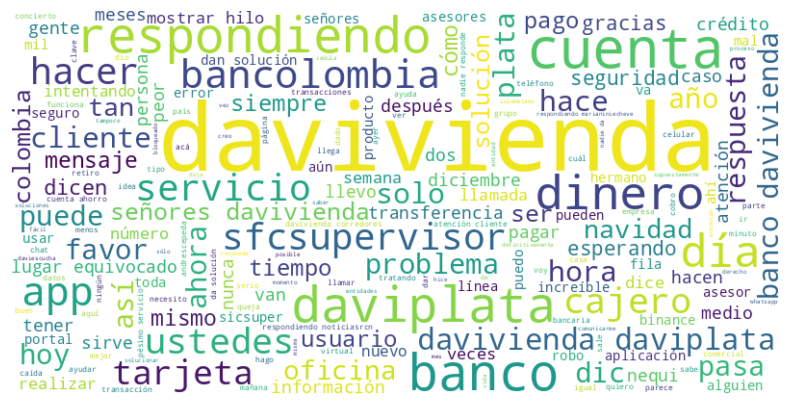

In [ ]:


# Importar CountVectorizer para transformar el texto en una matriz de términos
vectorizer = CountVectorizer(max_features=1000)

# Ajustar y transformar los datos de texto en una matriz de características
X = vectorizer.fit_transform(df_copy['Embedded_text_process'])

# Obtener las frecuencias de las palabras en la matriz de características
frecuencias_palabras = np.asarray(X.sum(axis=0)).flatten()

# Crear un DataFrame con las palabras y sus frecuencias
frecuencia_df = pd.DataFrame({'Palabra': vectorizer.get_feature_names_out(), 'Frecuencia': frecuencias_palabras})

# Ordenar el DataFrame por frecuencia de las palabras en orden descendente
frecuencia_df = frecuencia_df.sort_values(by='Frecuencia', ascending=False)

# Generar una nube de palabras a partir del texto procesado
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_copy['Embedded_text_process']))

# Visualizar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()




## Analizador de sentimientos I

In [ ]:

# Inicializar el analizador de sentimientos en español
sentiment = sentiment_analysis.SentimentAnalysisSpanish()

# Aplicar el análisis de sentimientos a la columna 'Embedded_text'
df_copy['Embedded_text_blob'] = df_copy['Embedded_text_process'].apply(lambda x: sentiment.sentiment(x))

# Mostrar las primeras 5 filas de la columna con el análisis de sentimientos
df_copy['Embedded_text_blob'].head()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


0    0.052709
1    0.895473
2    0.004789
3    0.008526
4    0.053349
Name: Embedded_text_blob, dtype: float64

## Sumarización de Texto usando Luhn Algorithm con Sumy

In [ ]:


def summarize_text_sumy(texto, cantidad_oraciones=1):
    """
    Resume el texto de entrada utilizando el algoritmo Luhn.

    Parámetros:
    texto (str): El texto de entrada que se va a resumir.
    cantidad_oraciones (int): Número de oraciones en el resumen (por defecto es 5).

    Retorna:
    str: El texto resumido.
    """
    # Crear un parser de texto plano con el texto de entrada
    parser = PlaintextParser.from_string(texto, Tokenizer("spanish"))
    # Inicializar el sumarizador Luhn
    summarizer = LuhnSummarizer()
    # Generar el resumen
    summary = summarizer(parser.document, cantidad_oraciones)
    # Combinar las oraciones para formar el texto del resumen
    texto_resumido = ' '.join([str(oracion) for oracion in summary])
    return texto_resumido



In [ ]:
# Aplicar la función summarize_text_sumy a la columna 'Embedded_text' y crear una nueva columna 'Embedded_text_Sumy'
df_copy['Embedded_text_Sumy'] = df_copy['Embedded_text'].apply(lambda x: summarize_text_sumy(x))

# Mostrar las primeras filas del DataFrame df_copy para verificar los resultados
df_copy

,Embedded_text,Embedded_text_process,Embedded_text_blob,Embedded_text_Sumy
0,la confianza se afectó el indicador de confian...,confianza afectó indicador confianza daviviend...,0.052709,la confianza se afectó el indicador de confian...
1,buscamos la accesibilidad mejor atención en tu...,buscamos accesibilidad mejor atención trámites...,0.895473,buscamos la accesibilidad mejor atención en tu...
2,señores davivienda no he podido ingresar mi ap...,señores davivienda no podido ingresar app davi...,0.004789,señores davivienda no he podido ingresar mi ap...
3,llevo toda una semana sufriendo intento de hur...,llevo toda semana sufriendo intento hurto medi...,0.008526,llevo toda una semana sufriendo intento de hur...
4,hemos retrocedido tanto en este país con este ...,retrocedido país gobierno malparidos cajeros d...,0.053349,hemos retrocedido tanto en este país con este ...
...,...,...,...,...
1781,respondiendo bcooccidente davivienda más si po...,respondiendo davivienda favor agradecería enor...,0.123209,respondiendo bcooccidente davivienda más si po...
1782,davidbarguil país se hampones esperando por m...,davidbarguil país hampones esperando meses sub...,0.003423,davidbarguil país se hampones esperando por me...
1784,davivienda deberían tener personal capacitado...,davivienda deberían tener personal capacitado ...,0.000064,davivienda deberían tener personal capacitado ...
1786,respondiendo gleniiaaa davivienda más hola gle...,respondiendo davivienda gracias escribirnos de...,0.341977,respondiendo gleniiaaa davivienda más hola gle...


## Análisis de Temas (Topic Modeling) con LDA

In [ ]:
'''
df_copy.drop(columns='index')
df_copy.apply(lambda col: col.drop_duplicates().reset_index(drop=True))

df_copy.columns'''

"\ndf_copy.drop(columns='index')\ndf_copy.apply(lambda col: col.drop_duplicates().reset_index(drop=True))\n\ndf_copy.columns"

Tema 0:
['davivienda', 'daviplata', 'no', 'solución', 'nadie', 'hermano', 'sfcsupervisor', 'dic', 'da', 'problema']
Tema 1:
['davivienda', 'no', 'servicio', 'banco', 'app', 'días', 'día', 'cliente', 'hacer', 'hace']
Tema 2:
['davivienda', 'no', 'respondiendo', 'cuenta', 'dinero', 'bancolombia', 'banco', 'hacer', 'cuentas', 'app']


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


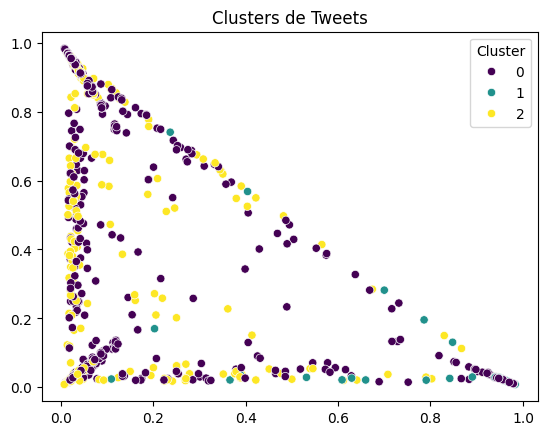

In [ ]:

# Crear un modelo LDA (Latent Dirichlet Allocation)
lda = LatentDirichletAllocation(n_components=3, random_state=42)
X = vectorizer.fit_transform(df_copy['Embedded_text_process'])
# Ajustar el modelo LDA a los datos
X_topics = lda.fit_transform(X)

# Obtener las palabras asociadas a cada tema
tema_palabras = vectorizer.get_feature_names_out()
for idx, tema in enumerate(lda.components_):
    print(f"Tema {idx}:")
    print([tema_palabras[i] for i in tema.argsort()[:-10 - 1:-1]])

# Clustering con K-means
kmeans = KMeans(n_clusters=3, random_state=42)
# Asignar las etiquetas de cluster a los datos
df_copy['Cluster'] = kmeans.fit_predict(X)

# Visualización de los Clusters
sns.scatterplot(x=X_topics[:, 0], y=X_topics[:, 1], hue=df_copy['Cluster'], palette='viridis')
plt.title('Clusters de Tweets')
plt.show()


## Determinación del número óptimo de clusters usando el método del codo

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


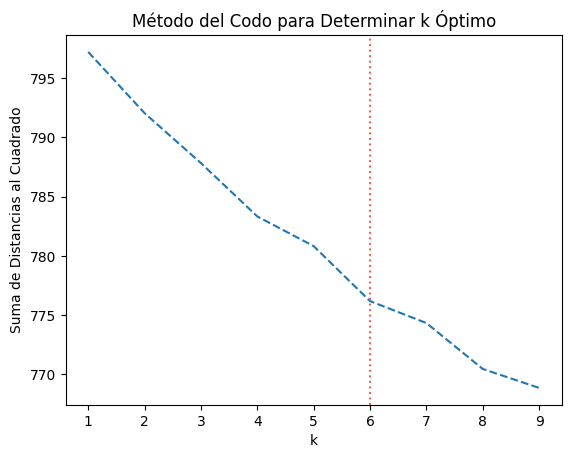

In [ ]:
# Vectorización usando TF-IDF (Term Frequency-Inverse Document Frequency)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_copy['Embedded_text_process'])

# Generar datos
K = range(1, 10)
Sum_of_squared_distances = []

# Calcular la suma de distancias al cuadrado para diferentes números de clusters
for k in K:
    km = KMeans(init="k-means++", n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

# Visualización del método del codo
ax = sns.lineplot(x=K, y=Sum_of_squared_distances)
ax.lines[0].set_linestyle("--")

# Añadir una línea vertical para mostrar el número óptimo de clusters
plt.axvline(6, color='#F26457', linestyle=':')

plt.xlabel('k')
plt.ylabel('Suma de Distancias al Cuadrado')
plt.title('Método del Codo para Determinar k Óptimo')
plt.show()

In [ ]:
# Verificar si la columna 'clusters' existe en el DataFrame
if 'clusters' in df.columns:
    df.drop('clusters', axis=1, inplace=True)
else:
    print("La columna 'clusters' no existe en el DataFrame.")

# Definir el número de clusters basándose en la gráfica anterior
k = 6
# Vectorizar el texto usando TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_copy['Embedded_text_process'])

# Inicializar y ajustar el modelo K-means
model = KMeans(init="k-means++", n_clusters=k, max_iter=25, n_init=1)
model.fit(X)

# Obtener las etiquetas de los clusters
clust_labels = model.predict(X)
cent = model.cluster_centers_

# Crear un DataFrame con las etiquetas de los clusters
kmeans_labels = pd.DataFrame(clust_labels)
df.insert((df.shape[1]),'clusters',kmeans_labels)

# Construir un DataFrame para mostrar las palabras clave de los clusters
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

results_dict = {}

for i in range(k):
    terms_list = []

    for ind in order_centroids[i, :15]:
        terms_list.append(terms[ind])

    results_dict[f'Cluster {i}'] = terms_list

df_clusters = pd.DataFrame.from_dict(results_dict)
df_clusters

La columna 'clusters' no existe en el DataFrame.


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
0,cuenta,bancolombia,respondiendo,daviplata,no,banco
1,davivienda,davivienda,davivienda,solución,davivienda,concierto
2,plata,página,lugar,hermano,dinero,davivienda
3,no,no,equivocado,nadie,app,hoy
4,nequi,caída,noticiasrcn,davivienda,sirve,navidad
5,ahorros,app,día,no,servicio,andrescepeda
6,cuentas,web,no,problema,pasa,httpsbitly
7,hicieron,vez,favor,discapacitado,hacer,saber
8,ustedes,veces,hacer,dan,daviplata,gran
9,cajeros,dos,tarjetas,da,sfcsupervisor,livedataifx


## Analizador de sentimientos II

In [ ]:
# Definir categorías para agrupación basándose en los resultados de la nube de palabras

categories = {
    "atencion al cliente": ["respuesta", "linea", "problema", "caso", "servicio", "solicitud", "ayuda", "atencion","hurto"],
    "soporte": ["app", "web", "acceso", "ingresar"],
    "marketing": ["comprar", "crédito", "cuenta", "beneficios"],
    "productos": ["daviplata", "corredores", "segurosbolivar", "cajero"]
}

['atencion al cliente', 'soporte', 'marketing', 'productos']
['respuesta', 'linea', 'problema', 'caso', 'servicio', 'solicitud', 'ayuda', 'atencion', 'hurto']
respuesta
linea
problema
caso
servicio
solicitud
ayuda
atencion
hurto
['app', 'web', 'acceso', 'ingresar']
app
web
acceso
ingresar
['comprar', 'crédito', 'cuenta', 'beneficios']
comprar
crédito
cuenta
beneficios
['daviplata', 'corredores', 'segurosbolivar', 'cajero']
daviplata
corredores
segurosbolivar
cajero
{'atencion al cliente': 2, 'soporte': 32, 'marketing': 4, 'productos': 86}


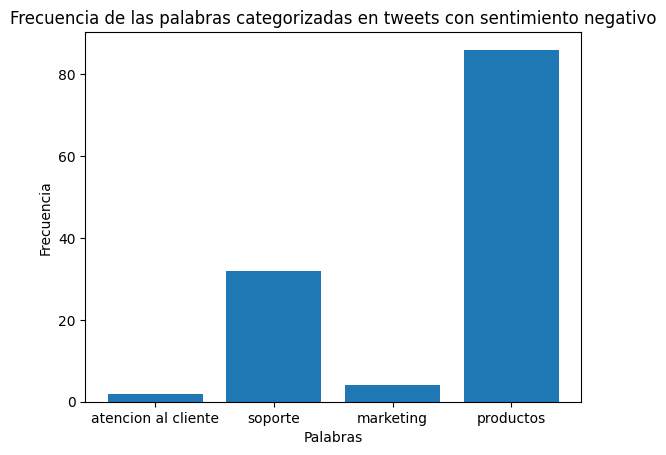

In [ ]:

# Cargar el archivo CSV en un DataFrame
df = pd.read_csv(file_path)

# Filtrar el DataFrame para incluir solo las filas donde la columna 'Embedded_text_blob' es menor que 0.5
df_filtered = df_copy[df_copy['Embedded_text_blob'] < 0.5]

# Definir las categorías de palabras clave
keywords = list(categories.keys())
print(keywords)
dic2={}
for i in keywords:
  count=0
  print(categories[i])
  for j in categories[i]:
    print(j)
    total = df_filtered['Embedded_text'].str.contains(j).sum()
    count=total+total
  dic2[i]=count
print(dic2)


# Crear un gráfico de barras para mostrar la frecuencia de las palabras categorizadas en tweets con sentimiento negativo
plt.bar(dic2.keys(),dic2.values())
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de las palabras categorizadas en tweets con sentimiento negativo')
plt.show()


In [ ]:
"""
    Resume una frase a su palabra más común después de procesarla. La frase de entrada que se va a resumir.

    Retorna:
    str: La palabra más común en la frase después del procesamiento.
    """

def summarize_to_one_word(sentence):

    # Tokenizar la frase
    palabras = word_tokenize(sentence.lower())

    # Eliminar puntuación
    palabras = [palabra for palabra in palabras if palabra.isalnum()]

    # Eliminar palabras vacías
    stop_words = set(stopwords.words('spanish'))
    palabras_filtradas = [palabra for palabra in palabras if palabra not in stop_words]

    # Distribución de frecuencias
    conteo_palabras = Counter(palabras_filtradas)

    # Obtener la palabra más común
    if conteo_palabras:
        palabra_mas_comun = conteo_palabras.most_common(1)[0][0]
    else:
        palabra_mas_comun = ""

    return palabra_mas_comun

df_copy['Embedded_text_word']=df_copy['Embedded_text'].apply(summarize_to_one_word)


In [ ]:
"""
Preprocesa un texto dividiéndolo en oraciones, tokenizando palabras, y eliminando puntuación y stopwords.

Parámetros:
text (str): El texto a procesar.

Retorna:
list: Una lista de listas de tokens limpios para cada oración.
"""

def preprocess_text(text):

    # Tokenizar las oraciones
    sentences = sent_tokenize(text)

    # Tokenizar palabras en cada oración
    word_tokens = [word_tokenize(sentence.lower()) for sentence in sentences]

    # Eliminar puntuación y stopwords
    stop_words = set(stopwords.words('spanish'))
    cleaned_tokens = [[word for word in sentence if word.isalnum() and word not in stop_words]
                      for sentence in word_tokens]

    return cleaned_tokens
"""
Entrena un modelo Word2Vec sobre los tokens proporcionados.

Parámetros:
tokens (list): Lista de listas de tokens para entrenar el modelo.

Retorna:
Word2Vec: El modelo Word2Vec entrenado.
"""
def train_word2vec_model(tokens):

    # Entrenar el modelo Word2Vec
    model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4)
    return model


"""
    Calcula la similitud entre dos palabras usando un modelo Word2Vec.

    Parámetros:
    model (Word2Vec): El modelo Word2Vec entrenado.
    word1 (str): Primera palabra.
    word2 (str): Segunda palabra.

    Retorna:
    float or None: El puntaje de similitud coseno entre las dos palabras, o None si alguna palabra no está en el vocabulario.
"""
def word_similarity(model, word1, word2):

    # Calcular la similitud entre las dos palabras
    if word1 in model.wv and word2 in model.wv:
        return model.wv.similarity(word1, word2)
    else:
        return None



In [ ]:
df_copy.head(11)

,Embedded_text,Embedded_text_process,Embedded_text_blob,Embedded_text_Sumy,Cluster,Embedded_text_word
0,la confianza se afectó el indicador de confian...,confianza afectó indicador confianza daviviend...,5.270935e-02,la confianza se afectó el indicador de confian...,0,confianza
1,buscamos la accesibilidad mejor atención en tu...,buscamos accesibilidad mejor atención trámites...,8.954733e-01,buscamos la accesibilidad mejor atención en tu...,0,banco
2,señores davivienda no he podido ingresar mi ap...,señores davivienda no podido ingresar app davi...,4.789020e-03,señores davivienda no he podido ingresar mi ap...,2,davivienda
3,llevo toda una semana sufriendo intento de hur...,llevo toda semana sufriendo intento hurto medi...,8.526024e-03,llevo toda una semana sufriendo intento de hur...,2,davivienda
4,hemos retrocedido tanto en este país con este ...,retrocedido país gobierno malparidos cajeros d...,5.334912e-02,hemos retrocedido tanto en este país con este ...,2,retrocedido
5,open data ceo pregúntele la gente de pie si es...,open data ceo pregúntele gente pie importa acá...,7.508893e-02,open data ceo pregúntele la gente de pie si es...,1,open
6,conoce los requisitos de la convocatoria de be...,conoce requisitos convocatoria becas talento f...,4.978923e-01,conoce los requisitos de la convocatoria de be...,0,conoce
7,mamado de ser adulto tener que trabajar para p...,mamado ser adulto tener trabajar pagarle daviv...,1.309338e-01,mamado de ser adulto tener que trabajar para p...,0,mamado
8,daviplata ayuda por favor llevo más de meses t...,daviplata ayuda favor llevo meses tratando cam...,4.880417e-08,daviplata ayuda por favor llevo más de meses t...,1,daviplata
9,cierto recuerdo en se vendieron empresas como ...,cierto recuerdo vendieron empresas bavaria col...,4.804439e-05,cierto recuerdo en se vendieron empresas como ...,0,grupo


In [ ]:
'''
Se crea un texto que contenga todos los tweets de la columna 'Embedded_text' con el fin de entrenar el modelo Word2Vec y
calcular la similitud entre dos palabras
'''
text = ''
for i in df_copy['Embedded_text_process']:
    text = text + i


# Preprocesar el texto
tokens = preprocess_text(text)

# Entrenar el modelo Word2Vec
model = train_word2vec_model(tokens)

# Medir la similitud entre palabras
word1 = df_copy['Embedded_text_word'][0]
word2 = "davivienda"
similarity = word_similarity(model, word1, word2)

#Imprimir valores de similitud
if similarity is not None:
    print(f"La similaridad '{word1}' y '{word2}' es: {similarity}")
else:
    print(f"No se encuentra referencias.")

La similaridad 'confianza' y 'davivienda' es: 0.018932780250906944
